# Visualising FITS and star positions

## Import modules

In [3]:
import requests, math, glob
import pandas as pd
import numpy as np
from photutils import DAOStarFinder
from astropy.stats import mad_std
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import Angle
import matplotlib.pyplot as plt
from photutils import aperture_photometry, CircularAperture
#from astroquery.simbad import Simbad
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import os
os.chdir('/home/jovyan/work/src')
import reading
import do_calibration

import importlib
importlib.reload(do_calibration)

%matplotlib inline
plt.style.use('seaborn')
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

## Set reference frame, global vars

In [4]:
refshort, reflong, refindex = do_calibration.get_reference_frame(100)
FITS_FILE=reflong
FITS_FILE_FTS=reflong
wcs_file = init.reference_header
PADDING = 200
print(FITS_FILE_FTS)

TypeError: get_reference_frame() missing 1 required positional argument: 'reference_method'

In [3]:
def getWcs(wcs_file):
    hdulist = fits.open(wcs_file)
    data = hdulist[0].data.astype(float)
    header = hdulist[0].header
    wcs = WCS(header)
    return wcs

wcs = getWcs(wcs_file)

#candidates = do_calibration.get_candidates(0.5)
hand_candidates_descr = do_calibration.get_star_descriptions(init.wwcra_certain_candidates)
#detections_catalog = do_calibration.create_detections_astropy_catalog(do_calibration.get_detected_stars())
detections = do_calibration.get_star_descriptions()
vsx_star_descr = do_calibration.get_vsx_in_field(detections, 0.01)

for star in vsx_star_descr:
    star.coords = star.match[0].coords
    print("jupyter:", star.coords)
    print("python:", star.local_id, star.coords, star.match)

Reading star descriptions for: [6314, 5978, 5557, 5430, 4962, 3368, 2535, 2058, 1870, 1636, 464, 441, 427, 363, 290, 277, 227, 205, 141]
Reading star descriptions for: all stars
Get VSX in field star descriptions
Creating vsx star catalog...
Creating astropy Catalog with 528255 objects...
Creating star_descriptions star catalog with 9999 stars...
Creating astropy Catalog with 9999 objects...
Found 19 VSX stars in field: [1915, 2052, 7092, 5187, 2674, 8387, 2842, 148, 1828, 7958, 6556, 646, 2247, 52, 3261, 8290, 7059, 9904, 9878]
jupyter: <SkyCoord (ICRS): (ra, dec) in deg
    ( 270.70646, -44.01222)>
python: 1915 <SkyCoord (ICRS): (ra, dec) in deg
    ( 270.70646, -44.01222)> [<star_description.CatalogMatch object at 0x7f54e2eb4748>]
jupyter: <SkyCoord (ICRS): (ra, dec) in deg
    ( 270.75171, -43.60442)>
python: 2052 <SkyCoord (ICRS): (ra, dec) in deg
    ( 270.75171, -43.60442)> [<star_description.CatalogMatch object at 0x7f54f8b9e198>]
jupyter: <SkyCoord (ICRS): (ra, dec) in deg
   

In [4]:
print(wcs)
for star in vsx_star_descr:
    print(star.coords, star.match[0].coords)
    thematch = star.match[0]
    #star.coords = star.match[0].coords
    #print("jupyter:", star.coords)
    #print("python:", star.local_id, star.coords, star.match[0])
    print(f'Catalog:{thematch.name_of_catalog}, CatalogId:{thematch.catalog_id}, Name:{thematch.name}, Coords:{thematch.coords}, Separation:{thematch.separation}')

<SkyCoord (ICRS): (ra, dec) in deg
    ( 270.70646, -44.01222)> <SkyCoord (ICRS): (ra, dec) in deg
    ( 270.70646, -44.01222)>
Catalog:VSX, CatalogId:V0395 CrA, Name:V0395 CrA, Coords:<SkyCoord (ICRS): (ra, dec) in deg
    ( 270.70646, -44.01222)>, Separation:0.0010152274965899832
<SkyCoord (ICRS): (ra, dec) in deg
    ( 270.75171, -43.60442)> <SkyCoord (ICRS): (ra, dec) in deg
    ( 270.75171, -43.60442)>
Catalog:VSX, CatalogId:ASAS J180300-4336.3, Name:ASAS J180300-4336.3, Coords:<SkyCoord (ICRS): (ra, dec) in deg
    ( 270.75171, -43.60442)>, Separation:0.0008256252192055836
<SkyCoord (ICRS): (ra, dec) in deg
    ( 270.78504, -43.55845)> <SkyCoord (ICRS): (ra, dec) in deg
    ( 270.78504, -43.55845)>
Catalog:VSX, CatalogId:ASASSN-V J180308.41-433330.4, Name:ASASSN-V J180308.41-433330.4, Coords:<SkyCoord (ICRS): (ra, dec) in deg
    ( 270.78504, -43.55845)>, Separation:0.00100294897901712
<SkyCoord (ICRS): (ra, dec) in deg
    ( 270.86088, -43.89063)> <SkyCoord (ICRS): (ra, dec) in 

## Get comparison Star

In [5]:
comparison_star_descr = do_calibration.get_star_descriptions([reading.read_comparison_star()])
center_coord = SkyCoord.from_pixel(wcs._naxis1/2.0, wcs._naxis2/2.0, wcs)
apass_star_descr = do_calibration.get_apass_star_descriptions(center_coord, Angle(0.67, unit=u.deg), row_limit=10000)
print(len(apass_star_descr))

Reference star: 104, Aperture: 8

Reading star descriptions for: [104]
5094


In [6]:

def set_local_id_label(star_descriptions):
    for star_descr in star_descriptions:
        star_descr.label = star_descr.local_id
    return star_descriptions

def set_aavso_id_label(star_descriptions):
    for star_descr in star_descriptions:
        star_descr.label = star_descr.aavso_id
    return star_descriptions

def set_custom_label(star_descriptions, label):
    for index, star_descr in enumerate(star_descriptions):
        star_descr.label = label if isinstance(label, list) else label[index]
    return star_descriptions

def add_pixels(results, offset):
    for star in results:
        star_coord = star.coords
        xy = SkyCoord.to_pixel(star_coord, wcs=wcs, origin=0)
        x = xy[0].item(0)
        y = xy[1].item(0)
        star.xpos = x + offset
        star.ypos = y + offset
    return results

big_green = set_custom_label(comparison_star_descr, 'comp')
# small_red = set_custom_label(apass_star_descr, [o.vmag for o in apass_star_descr])
# big_green = set_custom_label(vsx_star_descr, [o.match['catalog_dict']['name'] for o in vsx_star_descr])
# small_red = set_custom_label(hand_candidates_descr, [o.local_id for o in hand_candidates_descr])
big_green = set_aavso_id_label(vsx_star_descr)
small_red = set_local_id_label(hand_candidates_descr)

big_green = add_pixels(big_green, PADDING)
small_red = add_pixels(small_red, PADDING)
print("nr of found result:", len(big_green), len(small_red))

nr of found result: 19 19


## Draw the image

aavso.py		    fits2bitmap.py	results.txt
astropy_helper.py	    foo.png		run.sh
cmunipack		    init.py		secrets.py
cumul_histo_detections.png  init.pyc		sequence.sh
current			    inputfiles		star_description.py
do_aavso_report.py	    match.conf		startJupyter.sh
do_aperture.py		    muni.log		support
do_calibration.py	    muniphot.conf	test_catalog.bin
do_calibration.pyc	    notebooks		test.py
do_charts.py		    parse_photo_log.py	transfer
docker			    pngCurrent.sh	upsilon_extract.py
docker-compose.yml	    pngToMovie.sh	vsx_catalog.bin
do_field_charts.py	    __pycache__		vsx.dat
do_muniwin.py		    reading.py		vsx_pickle.py
do_profile.py		    reading.pyc		vsx.ReadMe
do_stats_charts.py	    README.md		wcs.fits
do_upsilon.py		    read_times.csv
dumpJupyter.py		    read_times.py
./inputfiles/testing/converted_fits/kout000069.fts


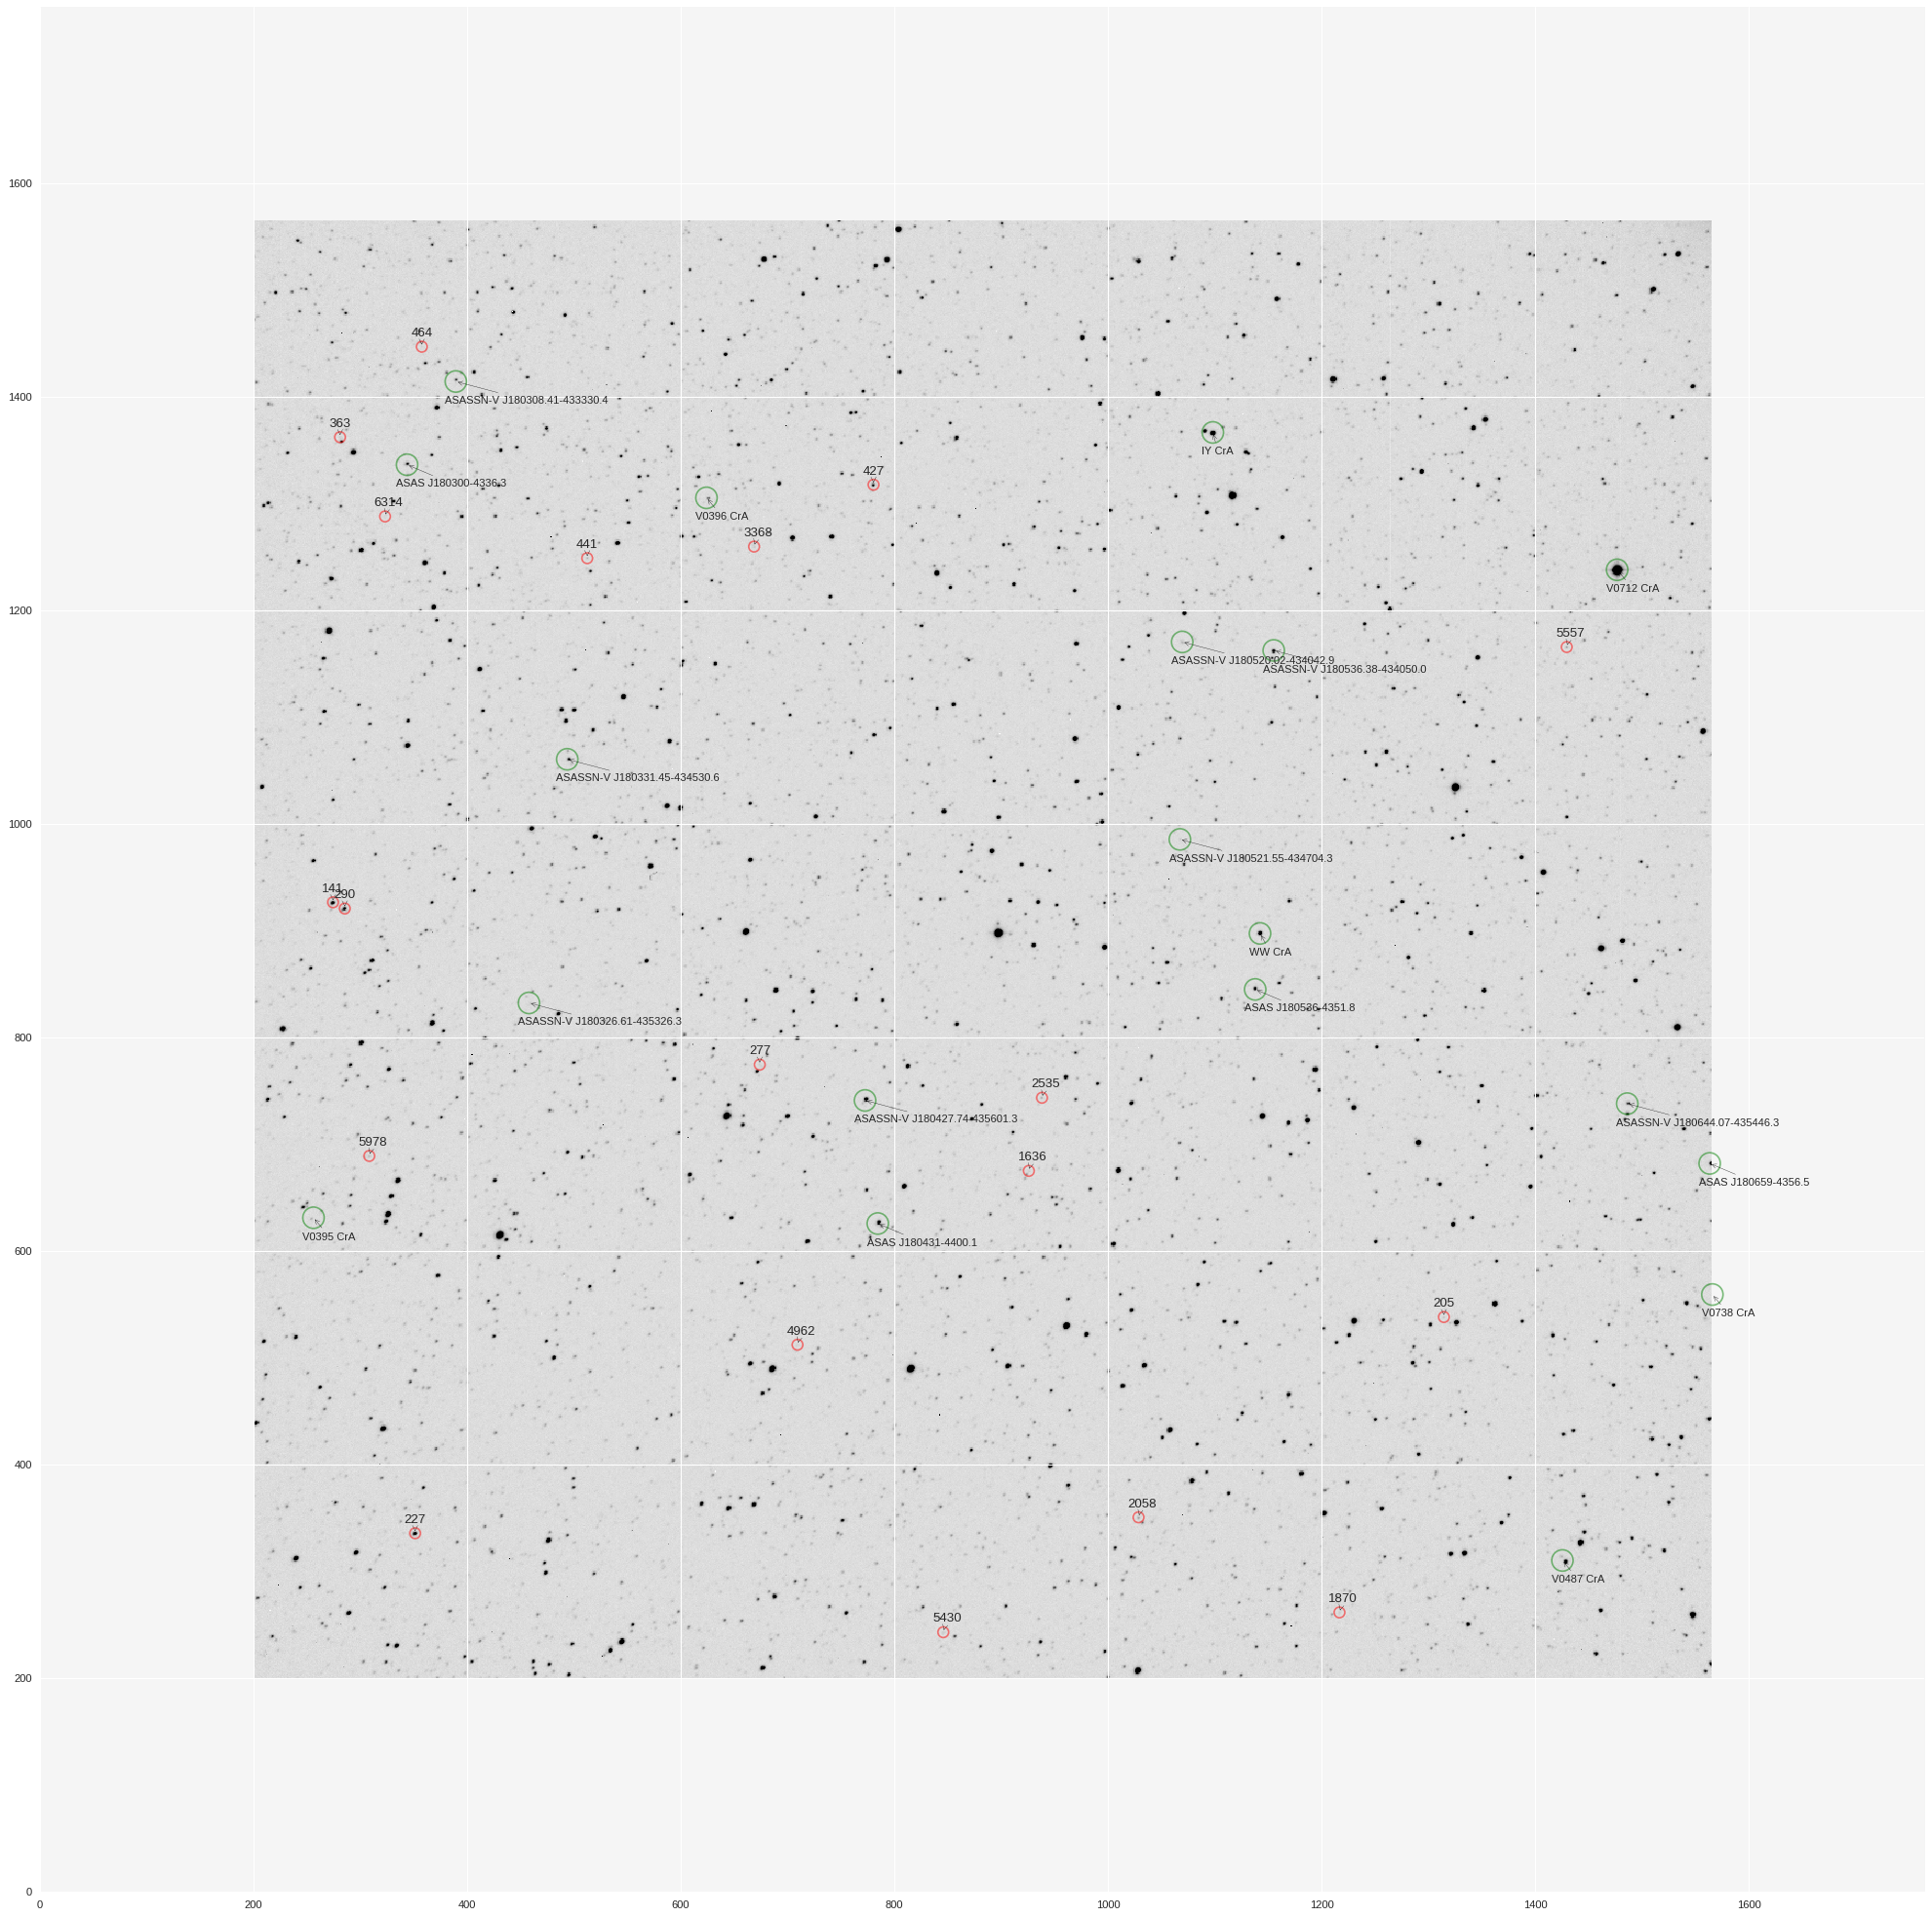

In [7]:
!ls
print(FITS_FILE)
#print(FITS_FILE_FTS)
#FITS_FILE='/home/jovyan/work'+ FITS_FILE[1:]
#print(FITS_FILE)
hdulist = fits.open(FITS_FILE)
data = hdulist[0].data.astype(float)

data = np.pad(data, (PADDING,PADDING), 'constant', constant_values=(100, 100))
fig=plt.figure(figsize=(36, 32), dpi= 80, facecolor='w', edgecolor='k')
big_green_positions = ([o.xpos for o in big_green],[o.ypos for o in big_green])
small_red_positions = ([o.xpos for o in small_red],[o.ypos for o in small_red])
big_green_apps = CircularAperture(big_green_positions, r=10.)    
small_red_apps = CircularAperture(small_red_positions, r=5.)    
# target_app = CircularAperture(target_xy, r=20.)    
plt.imshow(data, cmap='gray_r', origin='lower', vmin=0, vmax=2500)
big_green_apps.plot(color='green', lw=1.5, alpha=0.5)
small_red_apps.plot(color='red', lw=1.5, alpha=0.5)
# target_app.plot(color='blue', lw=1.5, alpha=0.5)
#to_plot = results
def annotate_it(results, offset1, offset2, size=16):
    for to_annotate in results:
        #star_name = to_annotate[1]['auid'] if to_annotate[1]['auid'] != 
        plt.annotate('{}'.format(to_annotate.label),
            xy=(to_annotate.xpos, to_annotate.ypos), xycoords='data',
            xytext=(offset1, offset2), textcoords='offset points', size=size, arrowprops=dict(arrowstyle="->"))
annotate_it(big_green, -10, -20, size=10)    
annotate_it(small_red, -10, 10, size=12)    


## Save the image

In [ ]:
fig.savefig(init.basedir+'known_vs_found_10k')
plt.close(fig)

ValueError: Could not determine celestial frame corresponding to the specified WCS object

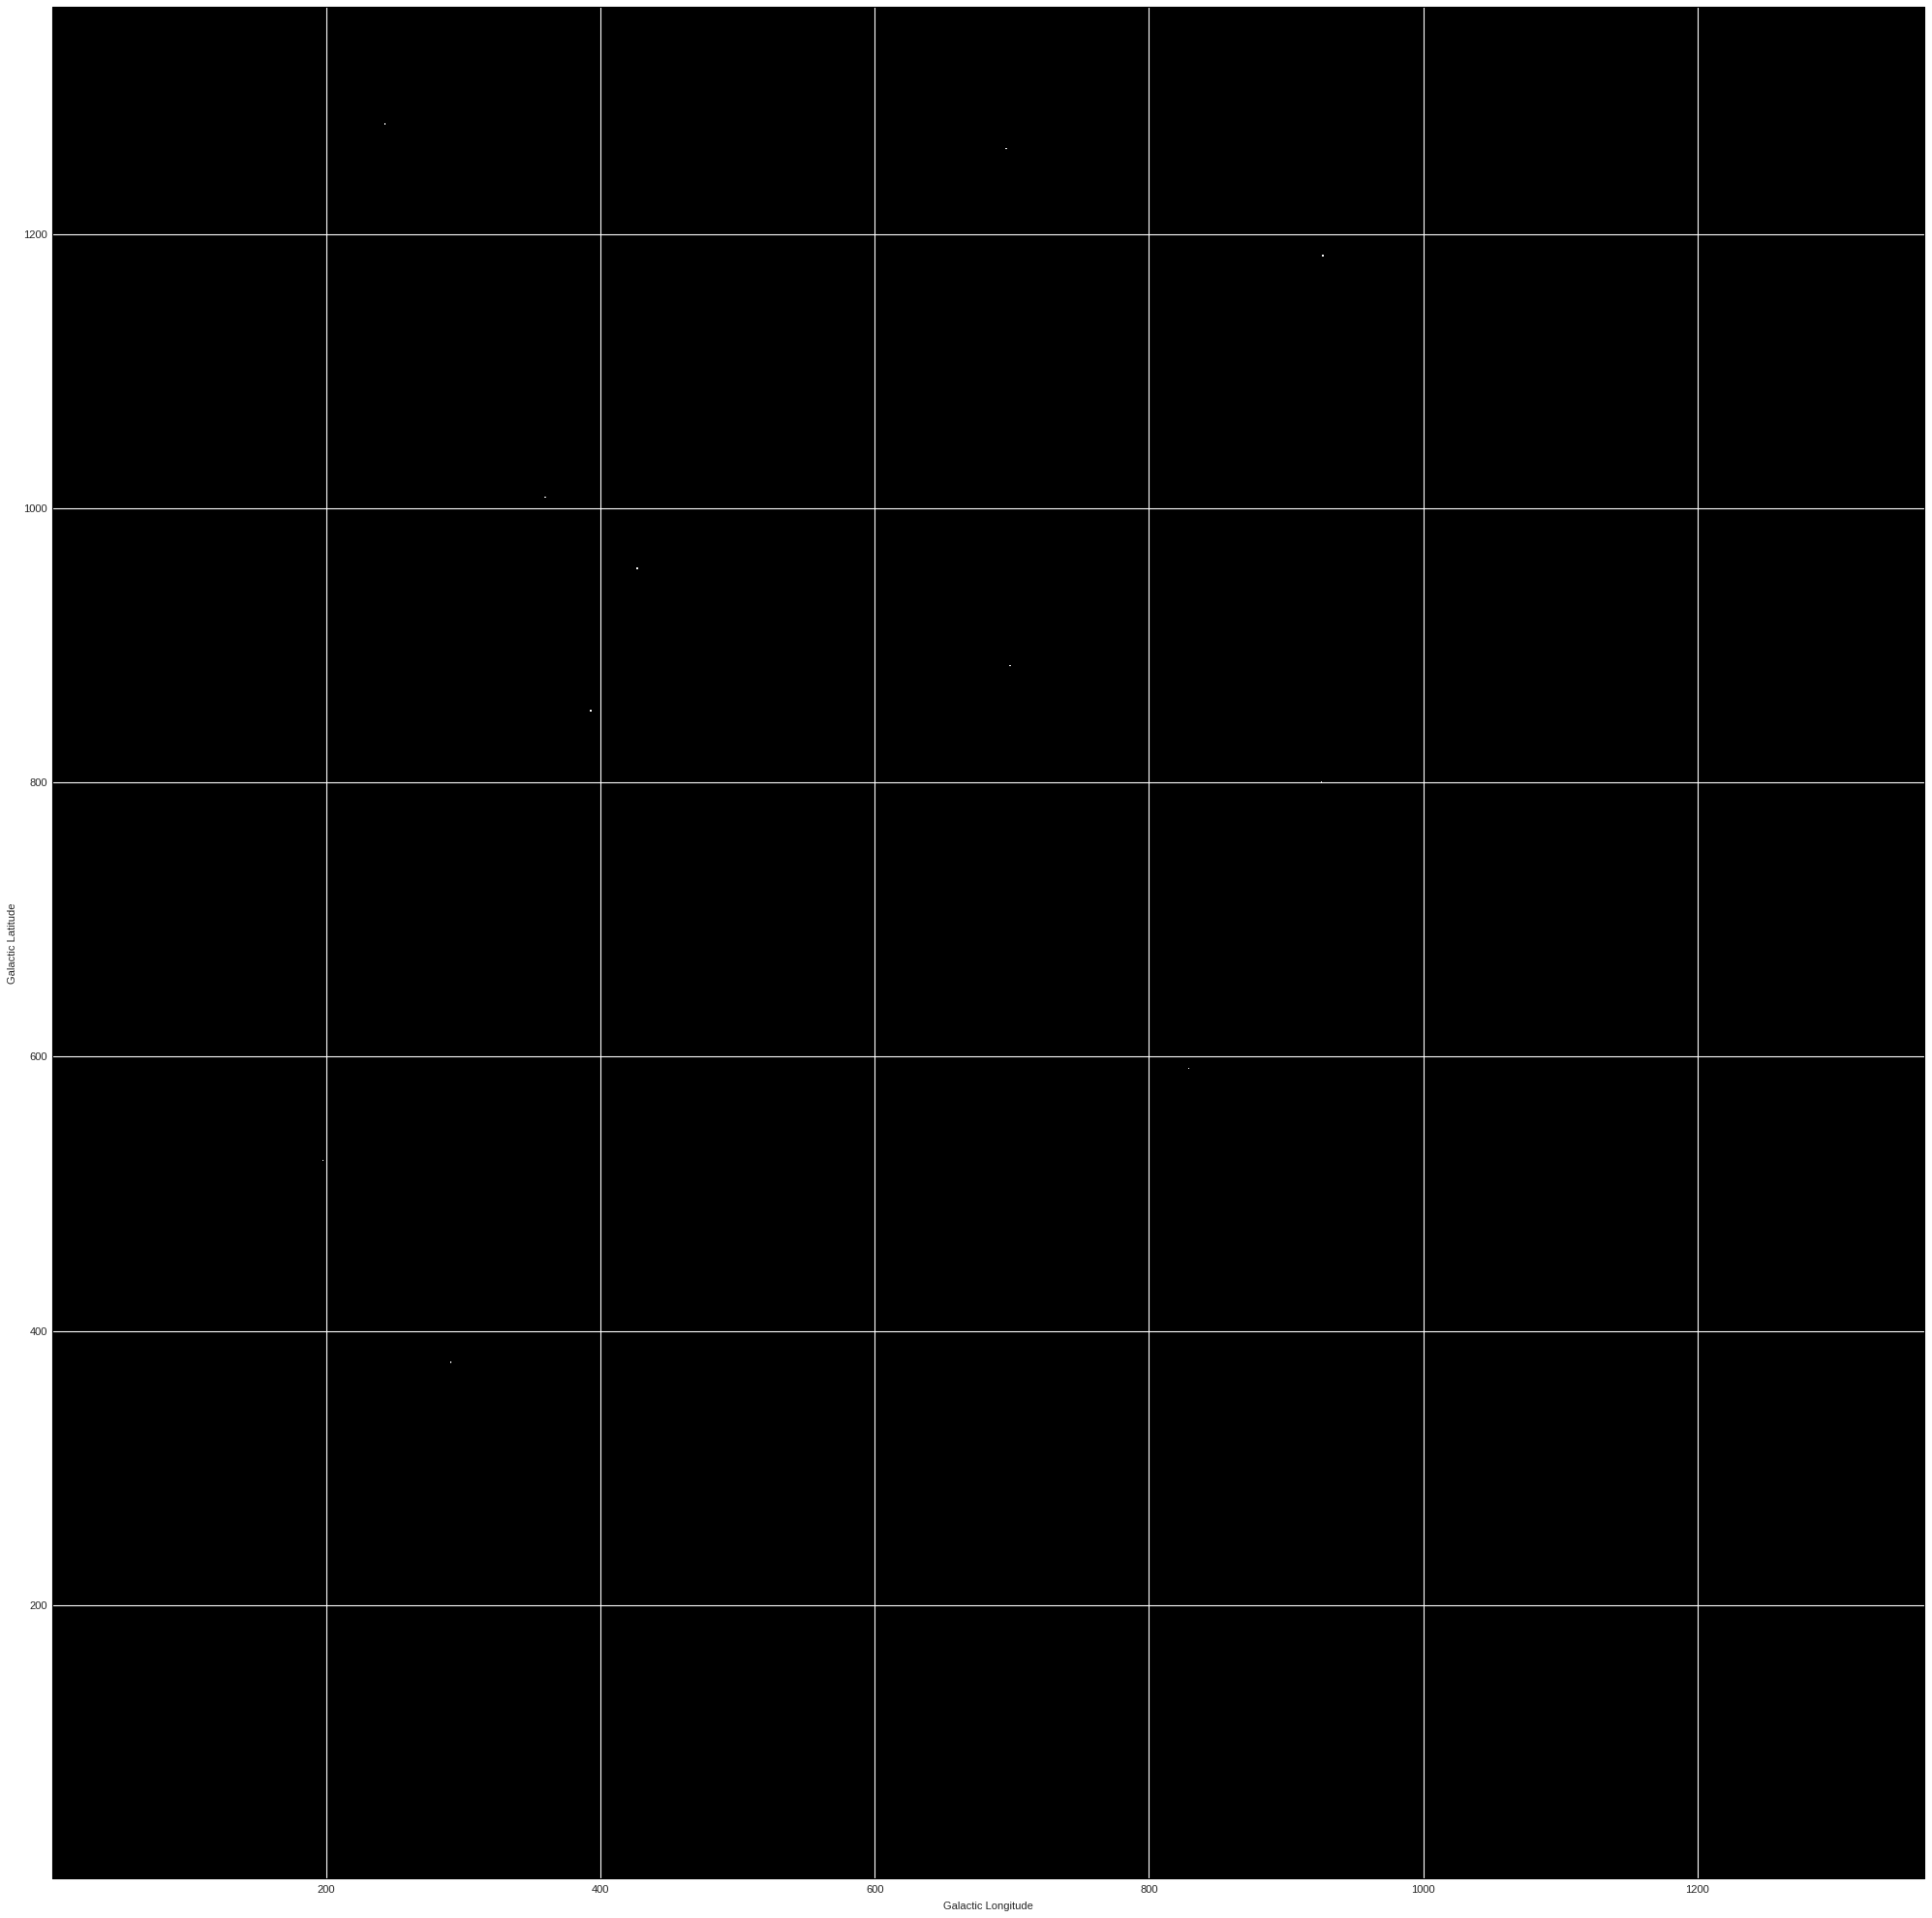

In [10]:
import matplotlib.pyplot as plt

from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

hdu = fits.open(FITS_FILE)[0]
wcs = WCS(hdu.header)
fig=plt.figure(figsize=(36, 32), dpi= 80, facecolor='w', edgecolor='k')

#plt.subplot(projection=wcs)
#plt.imshow(data, origin='lower', cmap='gray_r', vmin=0, vmax=2500)
#plt.grid(color='white', ls='solid')
#plt.xlabel('Galactic Longitude')
#plt.ylabel('Galactic Latitude')
ax = plt.subplot(projection=wcs)

ax.imshow(hdu.data, vmin=-2.e-5, vmax=2.e-4, origin='lower')

ax.coords.grid(True, color='white', ls='solid')
ax.coords[0].set_axislabel('Galactic Longitude')
ax.coords[1].set_axislabel('Galactic Latitude')

overlay = ax.get_coords_overlay('fk5')
overlay.grid(color='white', ls='dotted')
overlay[0].set_axislabel('Right Ascension (J2000)')
overlay[1].set_axislabel('Declination (J2000)')


In [18]:
dir(wcs)

['__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_all_pix2world',
 '_all_world2pix',
 '_array_converter',
 '_as_mpl_axes',
 '_denormalize_sky',
 '_det2im',
 '_fix_ctype',
 '_fix_scamp',
 '_get_naxis',
 '_naxis',
 '_naxis1',
 '_naxis2',
 '_normalize_sky',
 '_p4_pix2foc',
 '_pix2foc',
 '_read_d2im_old_format',
 '_read_det2im_kw',
 '_read_distortion_kw',
 '_read_sip_kw',
 '_remove_sip_kw',
 '_write_det2im',
 '_write_distortion_kw',
 '_write_sip_kw',
 'all_pix2world',
 'all_world2pix',
 'axis_type_names',
 'calc_footprint',
 'celestial',
 'copy',
 'cpdis1',
 'cpdis2',
 'deepcopy',
 'det2im',
 'det2im1',
 'det2im2',